In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

In [2]:
connection = mysql.connector.connect(
    host = 'localhost',
    user = 'root',
    password = '12345678',
    database = 'sales'
)

cursor = connection.cursor()

In [4]:
sql = """select round((Total_Revenue/10000000),2) 'Total_Revenue(Cr)', Year
        from ( SELECT round(sum(Final_Amount),2) Total_Revenue , YEAR(Order_Date) Year
            FROM sales.transaction t
            left join delivery_status d
                on t.Delivery_Status_Id = d.id
            where d.Name = 'delivered'
            group by YEAR(Order_Date)) a"""

df_yearly_rev = pd.read_sql(sql, connection)
df_yearly_rev['Revenue Growth(%)'] = df_yearly_rev['Total_Revenue(Cr)'].pct_change()*100

C:\Users\raagh\AppData\Local\Temp\ipykernel_11932\1807888920.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_yearly_rev = pd.read_sql(sql, connection)


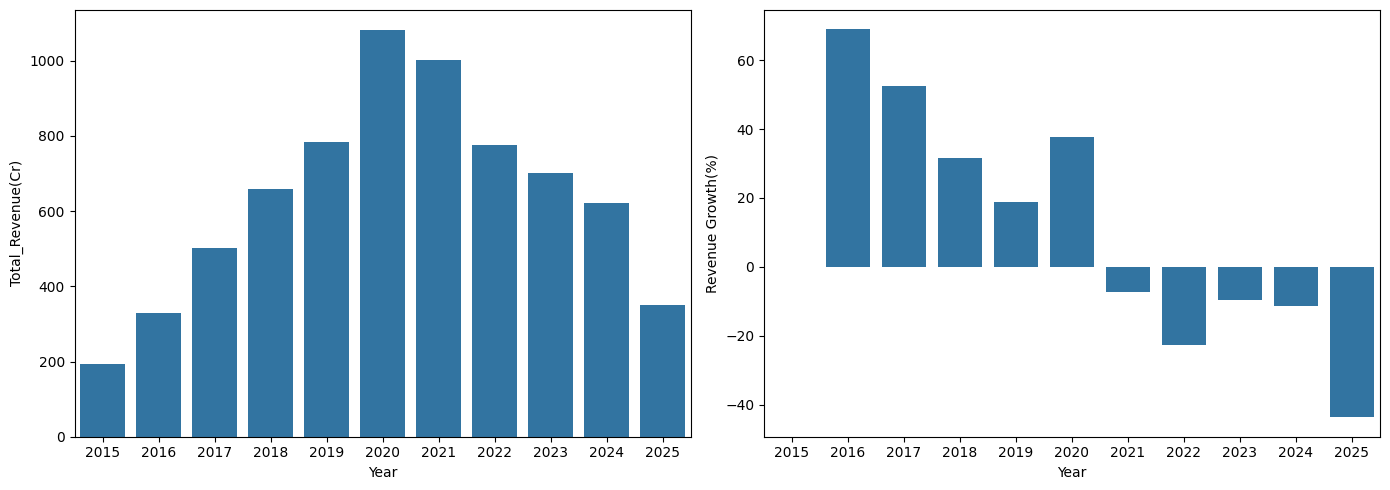

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.barplot(df_yearly_rev, x='Year', y='Total_Revenue(Cr)', ax=axes[0])
sns.barplot(df_yearly_rev, x='Year', y='Revenue Growth(%)', ax=axes[1])
plt.tight_layout()
plt.show()

In [6]:
plt.Figure(figsize=(4,12))
sns.lineplot(df_yearly_rev, x='Year', y='Total_Revenue(Cr)')
plt.show()

In [7]:
sql = """select round((Total_Revenue/10000000),2) 'Total_Revenue(Cr)', Year, Month
    from ( SELECT round(sum(Final_Amount),2) Total_Revenue , YEAR(Order_Date) Year, month(Order_Date) month
        FROM sales.transaction t
        left join delivery_status d
            on t.Delivery_Status_Id = d.id
        where d.Name = 'delivered'
        group by YEAR(Order_Date), month(Order_Date)) a"""

df_monthly_rev = pd.read_sql(sql, connection)
df_monthly_rev['Month_Name'] = pd.to_datetime(df_monthly_rev['Month'], format='%m').dt.strftime('%b')
df_monthly_rev

C:\Users\raagh\AppData\Local\Temp\ipykernel_11932\1936695254.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_monthly_rev = pd.read_sql(sql, connection)


Total_Revenue(Cr)  Year  Month Month_Name
0                14.70  2015      1        Jan
1                13.19  2015      2        Feb
2                13.34  2015      3        Mar
3                16.17  2015      4        Apr
4                14.39  2015      5        May
..                 ...   ...    ...        ...
127              29.19  2025      8        Aug
128              28.39  2025      9        Sep
129              28.71  2025     10        Oct
130              33.05  2025     11        Nov
131              46.80  2025     12        Dec

[132 rows x 4 columns]

<Axes: xlabel='Year', ylabel='Total_Revenue(Cr)'>

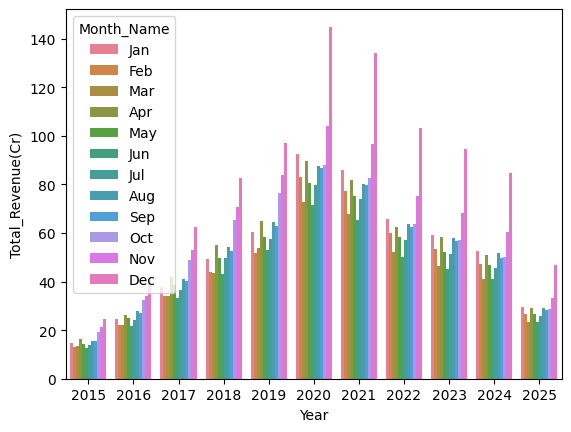

In [8]:
sns.barplot(df_monthly_rev, x='Year', y='Total_Revenue(Cr)' ,hue='Month_Name')

<Axes: xlabel='Year', ylabel='Total_Revenue(Cr)'>

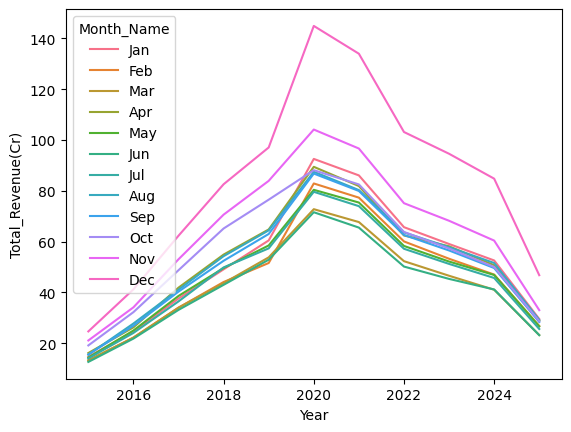

In [9]:
sns.lineplot(df_monthly_rev, x='Year', y='Total_Revenue(Cr)' ,hue='Month_Name')

Text(0.5, 1.0, 'Revenue Heatmap')

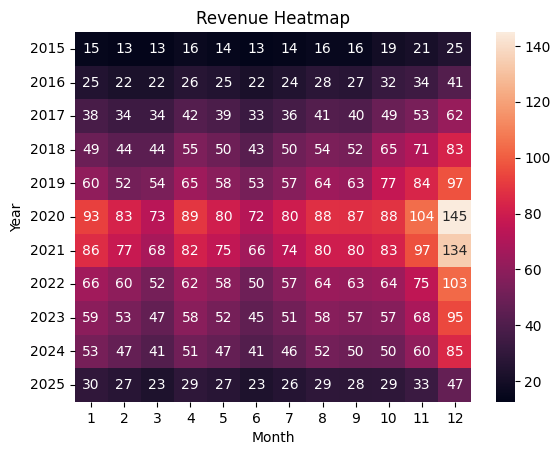

In [10]:
pivot_df = df_monthly_rev.pivot_table(
    index='Year',
    columns='Month',
    values='Total_Revenue(Cr)'
)
plt.Figure(figsize=(6,12))
sns.heatmap(pivot_df, annot=True, fmt='.0f')
plt.title("Revenue Heatmap")


In [ ]:
sql="""SELECT Customer_Id, round(Final_Amount,2) Amt_Spent ,Order_Date
    FROM sales.transaction t
    left join delivery_status d
        on t.Delivery_Status_Id = d.id
    where d.Name = 'delivered'"""

df_cust_purchase = pd.read_sql(sql, connection)

snapshot_date = df_cust_purchase['Order_Date'].max() + pd.Timedelta(days=1)
rfm = df_cust_purchase.groupby('Customer_Id').agg({
    'Order_Date': lambda x: (snapshot_date - x.max()).days,  # Recency
    'Customer_Id': 'count',                                    # Frequency
    'Amt_Spent': 'sum'                                            # Monetary
})

rfm.columns = ['Recency', 'Frequency', 'Monetary']

rfm['R_score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1])
rfm['F_score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])
rfm['M_score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5])
rfm['RFM_Score'] = rfm[['R_score','F_score','M_score']].astype(str).sum(axis=1)
rfm

C:\Users\raagh\AppData\Local\Temp\ipykernel_16516\1664300171.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_cust_purchase = pd.read_sql(sql, connection)


Recency  Frequency   Monetary R_score F_score M_score  \
Customer_Id                                                                 
CUST_2015_00000001     2574          4  171543.69       1       4       4   
CUST_2015_00000002     1156          9  538974.06       3       5       5   
CUST_2015_00000003     3031          7  377676.39       1       5       5   
CUST_2015_00000004     1640          6  733822.66       2       5       5   
CUST_2015_00000005     2827          4  238798.72       1       4       4   
...                     ...        ...        ...     ...     ...     ...   
CUST_2025_00027995      121          3   67331.17       5       4       2   
CUST_2025_00027997      129          1   25770.92       5       2       1   
CUST_2025_00027998       17          1   95998.21       5       2       2   
CUST_2025_00027999        8          2  105006.52       5       3       3   
CUST_2025_00028000       33          1   17377.85       5       2       1   

                   RFM_Score  
Customer_Id                   
CUST_2015_00000001       144  
CUST_2015_00000002       355  
CUST_2015_00000003       155  
CUST_2015_00000004       255  
CUST_2015_00000005       144  
...                      ...  
CUST_2025_00027995       542  
CUST_2025_00027997       521  
CUST_2025_00027998       522  
CUST_2025_00027999       533  
CUST_2025_00028000       521  

[345631 rows x 7 columns]

In [48]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 345631 entries, CUST_2015_00000001 to CUST_2025_00028000
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype   
---  ------     --------------   -----   
 0   Recency    345631 non-null  int64   
 1   Frequency  345631 non-null  int64   
 2   Monetary   345631 non-null  float64 
 3   R_score    345631 non-null  category
 4   F_score    345631 non-null  category
 5   M_score    345631 non-null  category
 6   RFM_Score  345631 non-null  object  
dtypes: category(3), float64(1), int64(2), object(1)
memory usage: 22.2+ MB


In [49]:

def segment(df):
    if df['RFM_Score'] == '555':
        return 'Champions'
    elif int(df['R_score']) >= 4 and int(df['F_score']) >= 4:
        return 'Loyal Customers'
    elif int(df['R_score'])  <= 2 and int(df['F_score']) <= 2:
        return 'At Risk'
    else:
        return 'Others'

rfm['Segment'] = rfm.apply(segment, axis=1)

In [51]:
plt.figure(figsize=(8,5))
sns.countplot(data=rfm, x='Segment')
#plt.xticks(rotation=45)
plt.title('Customer Segmentation (RFM)')
plt.show()

C:\Users\raagh\AppData\Local\Temp\ipykernel_16516\4052275430.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = rfm.pivot_table(index='R_score', columns='F_score', values='Monetary', aggfunc='mean')


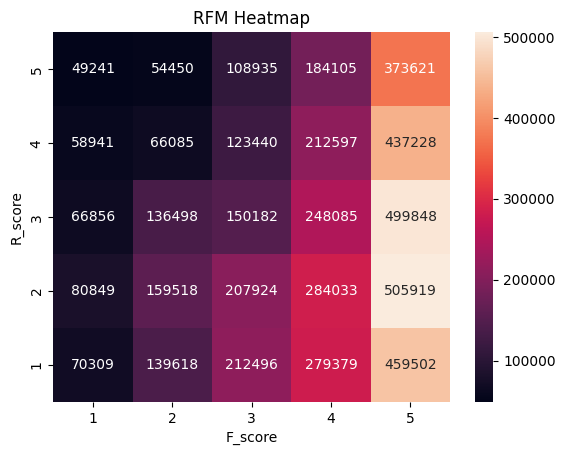

In [52]:
pivot = rfm.pivot_table(index='R_score', columns='F_score', values='Monetary', aggfunc='mean')

sns.heatmap(pivot, annot=True, fmt='.0f')
plt.title('RFM Heatmap')
plt.show()

In [12]:
sql = """select Payment_Method, round(amt/10000000, 2) Amount, Year
        from (select p.Name Payment_Method, sum(Final_Amount) amt, year(Order_Date) Year
            from transaction t
            join payment_method p
                on t.Payment_Method_Id = p.Id
            left join delivery_status d
                on t.Delivery_Status_Id = d.id
            where d.Name = 'delivered'
            group by p.Name, year(Order_Date))a"""

df_payment_method = pd.read_sql(sql, connection)
df_payment_method

C:\Users\raagh\AppData\Local\Temp\ipykernel_11932\3482915612.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_payment_method = pd.read_sql(sql, connection)


Payment_Method  Amount  Year
0            BNPL   15.63  2022
1            BNPL   28.54  2023
2            BNPL   36.64  2024
3            BNPL   23.83  2025
4             COD  146.05  2015
..            ...     ...   ...
59         Wallet   49.36  2021
60         Wallet   30.66  2022
61         Wallet   21.38  2023
62         Wallet   11.75  2024
63         Wallet    7.05  2025

[64 rows x 3 columns]

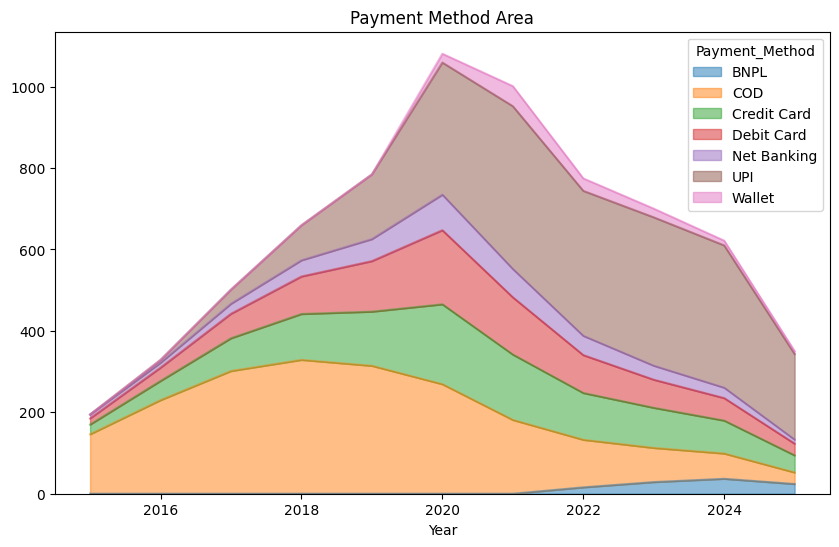

In [ ]:
pivot_df = df_payment_method.pivot(index='Year', columns='Payment_Method', values='Amount')

pivot_df.plot.area(figsize=(10,6), alpha=0.5)
plt.title("Payment Method")
plt.show()

In [3]:
sql = """select Name as Category_Name, Year, round((Total_Revenue/10000000),2) 'Total_Revenue(Cr)'
        from ( SELECT c.Name, sum(Final_Amount) Total_Revenue , YEAR(Order_Date) Year
            FROM sales.transaction t
            join Product p
                on t.Product_Id = p.Id
            join product_subcategory c
                on p.SubCategory_Id = c.Id
            left join delivery_status d
                on t.Delivery_Status_Id = d.id
            where d.Name = 'delivered'
            group by c.Name, YEAR(Order_Date)) a"""

df_cat_rev = pd.read_sql(sql, connection)
df_cat_rev

C:\Users\raagh\AppData\Local\Temp\ipykernel_13352\4131114040.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_cat_rev = pd.read_sql(sql, connection)


Category_Name  Year  Total_Revenue(Cr)
0                Audio  2015               1.55
1                Audio  2016               3.46
2                Audio  2017               5.27
3                Audio  2018               7.10
4                Audio  2019               9.01
..                 ...   ...                ...
61  TV & Entertainment  2021              25.33
62  TV & Entertainment  2022              16.44
63  TV & Entertainment  2023              17.42
64  TV & Entertainment  2024              15.32
65  TV & Entertainment  2025               7.63

[66 rows x 3 columns]

In [14]:
df_cat_rev['Year'].unique()

array([2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025])

In [4]:
sns.lineplot(df_cat_rev , x='Year', y='Total_Revenue(Cr)' ,hue='Category_Name')

<Axes: xlabel='Year', ylabel='Total_Revenue(Cr)'>

In [16]:
!pip3 install squarify


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
import squarify

years = df_cat_rev['Year'].unique()

fig, axes = plt.subplots(1, len(years), figsize=(14,6))

for i, year in enumerate(years):
    df_year = df_cat_rev[df_cat_rev['Year'] == year]
    
    squarify.plot(
        sizes=df_year['Total_Revenue(Cr)'],
        label=df_year['Category_Name'],
        ax=axes[i]
    )
    
    axes[i].set_title(f"{year}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

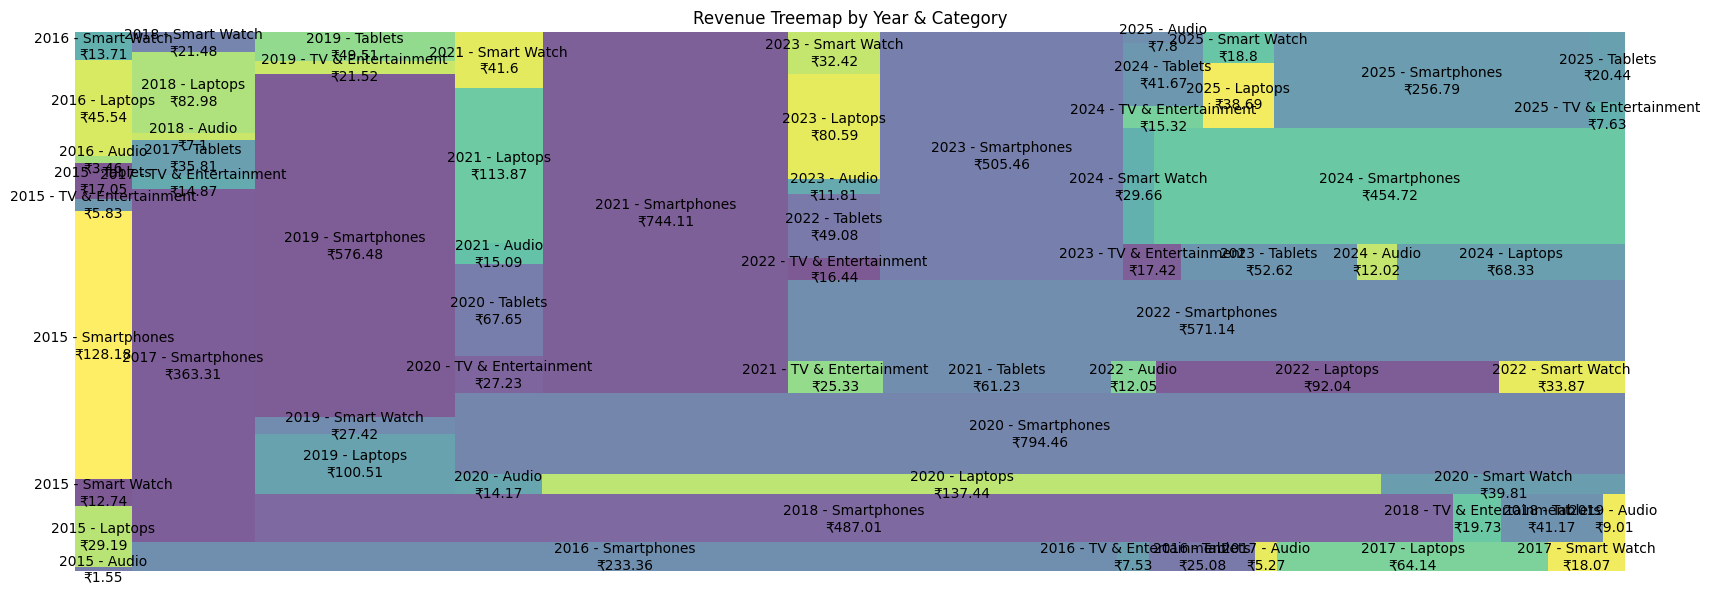

In [6]:
df_grouped = df_cat_rev.groupby(['Year','Category_Name'])['Total_Revenue(Cr)'].sum().reset_index()

labels = (
    df_grouped['Year'].astype(str) + " - " +
    df_grouped['Category_Name'] + "\n₹" +
    df_grouped['Total_Revenue(Cr)'].astype(str)
)

plt.figure(figsize=(20,7))

squarify.plot(
    sizes=df_grouped['Total_Revenue(Cr)'],
    label=labels,
    alpha=0.7
)

plt.title("Revenue Treemap by Year & Category")
plt.axis('off')
plt.show()  

In [7]:
pivot_df = df_cat_rev.pivot(index='Year', columns='Category_Name', values='Total_Revenue(Cr)').reset_index()
pivot_df

Category_Name  Year  Audio  Laptops  Smart Watch  Smartphones  \
0              2015   1.55    29.19        12.74       128.18   
1              2016   3.46    45.54        13.71       233.36   
2              2017   5.27    64.14        18.07       363.31   
3              2018   7.10    82.98        21.48       487.01   
4              2019   9.01   100.51        27.42       576.48   
5              2020  14.17   137.44        39.81       794.46   
6              2021  15.09   113.87        41.60       744.11   
7              2022  12.05    92.04        33.87       571.14   
8              2023  11.81    80.59        32.42       505.46   
9              2024  12.02    68.33        29.66       454.72   
10             2025   7.80    38.69        18.80       256.79   

Category_Name  TV & Entertainment  Tablets  
0                            5.83    17.05  
1                            7.53    25.08  
2                           14.87    35.81  
3                           19.73    41.17  
4                           21.52    49.51  
5                           27.23    67.65  
6                           25.33    61.23  
7                           16.44    49.08  
8                           17.42    52.62  
9                           15.32    41.67  
10                           7.63    20.44

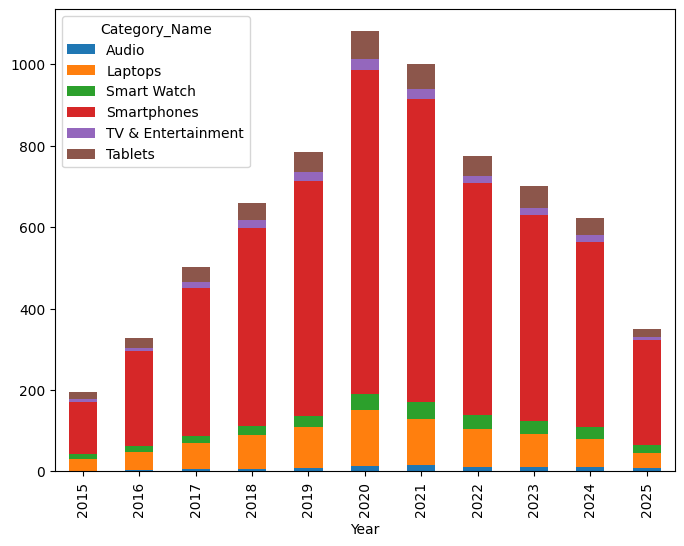

In [ ]:
# sns.barplot(df_cat_rev,x='Year', y='Total_Revenue(Cr)', hue='Category_Name', )
fig, ax = plt.subplots(figsize=(8, 6))
pivot_df.plot(kind='bar', x='Year', stacked=True, figsize=(8, 6), ax=ax )
plt.ylabel = 'Revenue (Cr)'
plt.show()

In [11]:
import math
years = sorted(df_cat_rev['Year'].unique())
n = len(years)

cols = 3
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 5*rows))
axes = axes.flatten()
    
for ax, year in zip(axes, years):
    df_year = df_cat_rev[df_cat_rev['Year'] == year]
    
    wedges, texts, autotexts = ax.pie(
        df_year['Total_Revenue(Cr)'],
        labels=df_year['Category_Name'],
        autopct='%1.1f%%',
        startangle=90
    )
    
    centre_circle = plt.Circle((0,0), 0.60, fc='white')
    ax.add_artist(centre_circle)
    
    ax.set_title(f"{year}")

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

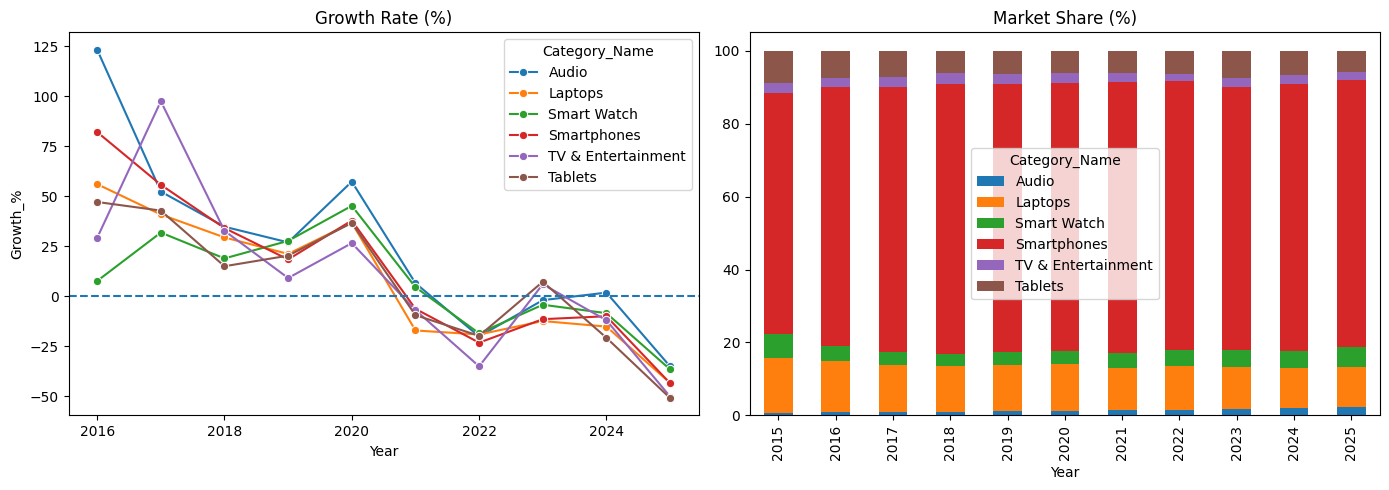

In [12]:
#Market share
df_cat_rev['Total_Year_Revenue'] = df_cat_rev.groupby('Year')['Total_Revenue(Cr)'].transform('sum')

df_cat_rev['Market_Share_%'] = (
    df_cat_rev['Total_Revenue(Cr)'] / df_cat_rev['Total_Year_Revenue'] * 100
)

#Growth rate
df_cat_rev = df_cat_rev.sort_values(['Category_Name','Year'])

df_cat_rev['Growth_%'] = (
    df_cat_rev.groupby('Category_Name')['Total_Revenue(Cr)']
      .pct_change() * 100
)

fig, axes = plt.subplots(1,2, figsize=(14,5))

# Growth Plot
sns.lineplot(data=df_cat_rev, x='Year', y='Growth_%', hue='Category_Name', marker='o', ax=axes[0])
axes[0].set_title("Growth Rate (%)")
axes[0].axhline(0, linestyle='--')

# Market Share
pivot_share = df_cat_rev.pivot(index='Year', columns='Category_Name', values='Market_Share_%')
pivot_share.plot(kind='bar', stacked=True, ax=axes[1])
axes[1].set_title("Market Share (%)")

plt.tight_layout()
plt.show()


In [3]:
sql = """select round(amt/10000000,2) revenue, cnt membership, Name category, Is_Prime_Member
        from (select sum(t.Final_Amount) amt, count(t.customer_id) cnt, s.Name, c.Is_Prime_Member
        from transaction t
        join customer c
            on t.customer_id = c.id
        join product p
            on t.product_id = p.id
        join product_subcategory s
            on p.subcategory_Id = s.id
        group by s.Name, c.Is_Prime_Member)a"""

df_memb_rev = pd.read_sql(sql, connection)
df_memb_rev

C:\Users\raagh\AppData\Local\Temp\ipykernel_1672\74761328.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_memb_rev = pd.read_sql(sql, connection)


revenue  membership            category  Is_Prime_Member
0    278.69       44846         Smartphones                0
1   5308.37      778227         Smartphones                1
2    891.11       83473             Laptops                1
3     44.12        4428             Laptops                0
4    479.94       65931             Tablets                1
5     25.99        3996             Tablets                0
6    104.03       47182               Audio                1
7      6.52        3191               Audio                0
8    301.64       70029         Smart Watch                1
9     18.15        4306         Smart Watch                0
10   182.49       15574  TV & Entertainment                1
11     8.78         816  TV & Entertainment                0

In [10]:
df_memb_rev['avg_revenue'] = ((df_memb_rev['revenue'] * 10000000)/df_memb_rev['membership']).round(2)
df_memb_rev

revenue  membership            category  Is_Prime_Member  avg_revenue
0    278.69       44846         Smartphones                0     62143.78
1   5308.37      778227         Smartphones                1     68211.07
2    891.11       83473             Laptops                1    106754.28
3     44.12        4428             Laptops                0     99638.66
4    479.94       65931             Tablets                1     72794.28
5     25.99        3996             Tablets                0     65040.04
6    104.03       47182               Audio                1     22048.66
7      6.52        3191               Audio                0     20432.47
8    301.64       70029         Smart Watch                1     43073.58
9     18.15        4306         Smart Watch                0     42150.49
10   182.49       15574  TV & Entertainment                1    117176.06
11     8.78         816  TV & Entertainment                0    107598.04

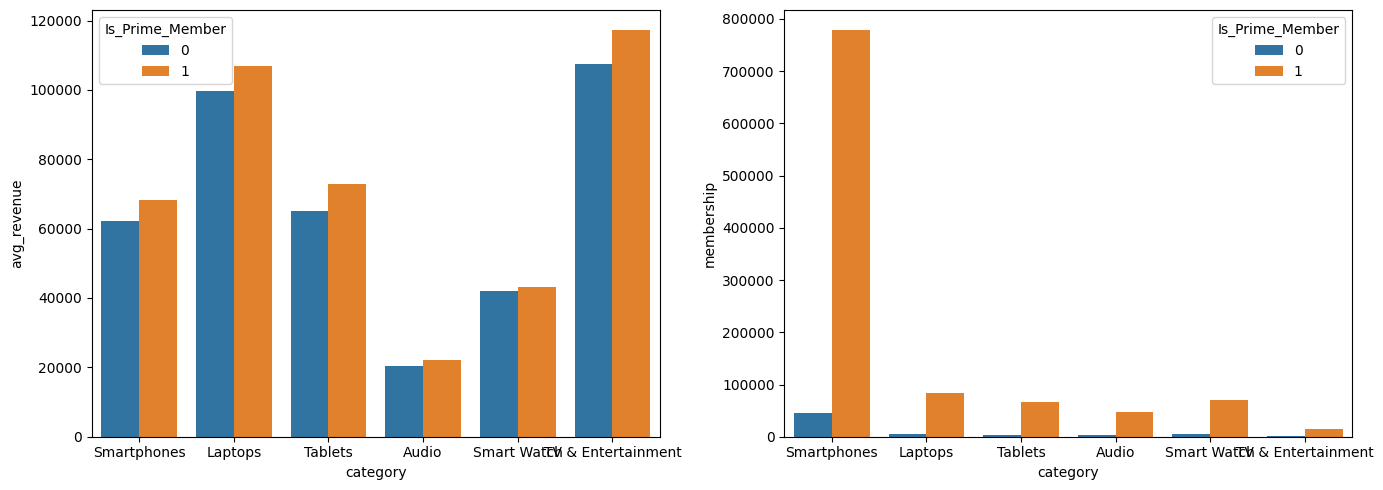

In [14]:
fig, axes = plt.subplots(1,2, figsize=(14,5))
sns.barplot(df_memb_rev, x='category', y='avg_revenue', hue='Is_Prime_Member', ax=axes[0])
sns.barplot(df_memb_rev, x='category', y='membership', hue='Is_Prime_Member', ax=axes[1])
plt.tight_layout()

In [6]:
sql = """select state, city, citytier, round(amt/10000000, 2) revenue, year
        from (select s.name state, y.name city, r.tier citytier, sum(Final_Amount) amt, year(order_date) year
            from transaction t
            join customer c
                on t.customer_id = c.id
            left join state s
                on c.state_id = s.id
            left join city y
                on c.city_id = y.id
            left join Customer_Tier r
                on c.customer_tier_id = r.Id
            group by s.name, y.name, r.tier, year(order_date)) a"""

df_geo_rev = pd.read_sql(sql, connection)
df_geo_rev

C:\Users\raagh\AppData\Local\Temp\ipykernel_12088\911539124.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_geo_rev = pd.read_sql(sql, connection)


state           city citytier  revenue  year
0    Andhra Pradesh  Visakhapatnam    Tier2     2.27  2015
1    Andhra Pradesh  Visakhapatnam    Tier2     3.86  2016
2    Andhra Pradesh  Visakhapatnam    Tier2     6.88  2017
3    Andhra Pradesh  Visakhapatnam    Tier2     9.70  2018
4    Andhra Pradesh  Visakhapatnam    Tier2    13.38  2019
..              ...            ...      ...      ...   ...
325     West Bengal        Kolkata    Metro    69.55  2021
326     West Bengal        Kolkata    Metro    50.42  2022
327     West Bengal        Kolkata    Metro    44.03  2023
328     West Bengal        Kolkata    Metro    35.91  2024
329     West Bengal        Kolkata    Metro    20.99  2025

[330 rows x 5 columns]

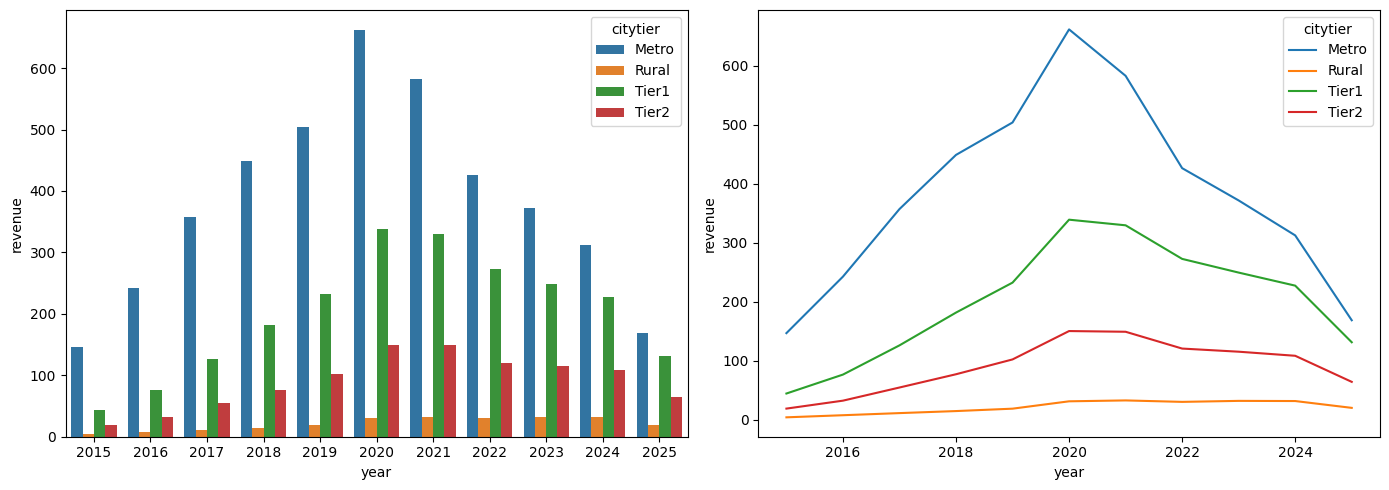

In [7]:
import plotly.express as px

df_tier_grp = df_geo_rev.groupby(['year','citytier']).sum('revenue').reset_index()
pivot_tier = df_tier_grp.pivot(index='year', columns=['citytier'], values='revenue')

fig, axes = plt.subplots(1,2, figsize=(14,5))
sns.barplot(df_tier_grp, x='year', y='revenue', hue='citytier', ax=axes[0])
sns.lineplot(df_tier_grp, x='year', y='revenue', hue='citytier', ax=axes[1])
plt.tight_layout()


In [31]:
!pip3 install --upgrade nbformat


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
import plotly.express as px
import nbformat
df_city_grp = df_geo_rev.groupby(['year','city']).sum('revenue').reset_index()
fig = px.line(df_city_grp, x='year', y='revenue', color="city", symbol="city")
fig.show()
plt.tight_layout()

<Figure size 640x480 with 0 Axes>

In [ ]:
sql = """select festive_name, a.year, round(revenue/(datediff(ma,mi) * 100000), 2) 'avg_revenue(lk)', avg_amt
        from (select min(order_date) mi,max(Order_Date) ma, f.name festive_name, year(Order_Date) year, sum(Final_Amount) revenue
                from transaction t 
                join festive_sale f
                    on t.Festive_Sale_Id = f.id
                where Festive_Sale_Id is not null
                group by f.name, year(Order_Date))a
        join (select round(sum(Final_Amount)/(365*100000),2) avg_amt, year(order_date) year
                from transaction
                where IFNULL(Is_Festival_Sale, false) = false 
                group by year(Order_Date)) b
            on a.year = b.year"""

df_fest_rev = pd.read_sql(sql, connection)
df_fest_rev

C:\Users\raagh\AppData\Local\Temp\ipykernel_12088\707923001.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_fest_rev = pd.read_sql(sql, connection)


festive_name  year  avg_revenue(lk)  avg_amt
0   Amazon Great Indian Festival  2015            50.12     4.05
1   Amazon Great Indian Festival  2016            86.69     6.84
2   Amazon Great Indian Festival  2017           125.53    10.54
3   Amazon Great Indian Festival  2018           164.51    13.59
4   Amazon Great Indian Festival  2019           196.96    16.01
..                           ...   ...              ...      ...
83                Valentine Sale  2021           253.91    21.04
84                Valentine Sale  2022           183.59    16.75
85                Valentine Sale  2023           169.34    14.99
86                Valentine Sale  2024           154.04    13.38
87                Valentine Sale  2025            85.44     7.40

[88 rows x 4 columns]

In [9]:
fig = px.line(df_fest_rev, x='year', y='avg_revenue(lk)', color="festive_name", symbol="festive_name")
fig.show()
plt.tight_layout()

<Figure size 640x480 with 0 Axes>

In [12]:
pivot_fest = df_fest_rev.pivot(index='year', columns='festive_name', values='avg_revenue(lk)')
pivot_fest = pivot_fest.merge(df_fest_rev.drop_duplicates(subset=['year','avg_amt'])[['year','avg_amt']], left_on='year', right_on='year')
pivot_fest

year  Amazon Great Indian Festival  Back to School  Diwali Sale  \
0   2015                         50.12           38.27        59.21   
1   2016                         86.69           66.12        93.58   
2   2017                        125.53          100.14       148.65   
3   2018                        164.51          133.79       198.71   
4   2019                        196.96          158.18       229.09   
5   2020                        246.17          212.80       274.91   
6   2021                        235.46          198.60       250.92   
7   2022                        185.15          153.70       198.66   
8   2023                        158.59          141.33       177.14   
9   2024                        141.58          125.25       156.46   
10  2025                         79.92           69.42        88.64   

    Holi Festival  Prime Day  Republic Day Sale  Summer Sale  Valentine Sale  \
0           38.14      63.00              42.29        43.64           42.05   
1           61.34     105.98              73.18        68.05           73.27   
2           95.90     148.08             106.91       108.48          108.44   
3          122.65     197.76             138.08       142.06          148.08   
4          155.41     251.93             170.35       172.15          175.19   
5          203.24     321.43             245.76       230.79          262.64   
6          194.07     326.34             241.71       216.60          253.91   
7          150.81     250.18             176.11       167.70          183.59   
8          134.82     218.18             162.62       147.52          169.34   
9          115.12     183.25             155.41       135.98          154.04   
10          68.42     100.14              79.97        73.26           85.44   

    avg_amt  
0      4.05  
1      6.84  
2     10.54  
3     13.59  
4     16.01  
5     23.31  
6     21.04  
7     16.75  
8     14.99  
9     13.38  
10     7.40

In [13]:
unpivot_fest = pivot_fest.melt(id_vars='year', value_vars=['Amazon Great Indian Festival', 'Back to School', 'Diwali Sale',
       'Holi Festival', 'Prime Day', 'Republic Day Sale', 'Summer Sale',
       'Valentine Sale', 'avg_amt'])
unpivot_fest

year                      variable   value
0   2015  Amazon Great Indian Festival   50.12
1   2016  Amazon Great Indian Festival   86.69
2   2017  Amazon Great Indian Festival  125.53
3   2018  Amazon Great Indian Festival  164.51
4   2019  Amazon Great Indian Festival  196.96
..   ...                           ...     ...
94  2021                       avg_amt   21.04
95  2022                       avg_amt   16.75
96  2023                       avg_amt   14.99
97  2024                       avg_amt   13.38
98  2025                       avg_amt    7.40

[99 rows x 3 columns]

In [14]:
fig = px.line(unpivot_fest, x='year', y='value', color="variable", symbol="variable")
fig.show()
plt.tight_layout()

<Figure size 640x480 with 0 Axes>

In [17]:
sql = """select a.Age_Group, s.Tier, y.Name category, count(customer_id) customers, round(sum(Final_Amount)/10000000, 2)  Revenue
        from transaction t
        join customer c
            on t.customer_id = c.id
        join customer_age_group a
            on c.Customer_Age_Group_Id = a.Id
        left join Customer_SpendingTier s
            on c.Customer_SpendingTier_Id = s.id
        join product p
            on t.product_id = p.id
        join product_subcategory y
            on p.SubCategory_Id = y.id
        group by a.Age_Group, s.Tier, y.Name"""

df_age_rev = pd.read_sql(sql, connection)
df_age_rev

C:\Users\raagh\AppData\Local\Temp\ipykernel_12088\2169991922.py:15: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



Age_Group     Tier            category  customers  Revenue
0      36-45  Premium         Smartphones      26157   354.93
1      18-25  Premium         Smartphones      41385   568.89
2      26-35  Premium         Smartphones      45198   622.17
3      46-55  Premium         Smartphones      12657   174.93
4        55+  Premium         Smartphones       3847    52.08
..       ...      ...                 ...        ...      ...
84     36-45   Budget  TV & Entertainment        204     0.92
85     18-25   Budget  TV & Entertainment        314     1.41
86     26-35   Budget  TV & Entertainment        373     1.66
87     46-55   Budget  TV & Entertainment         96     0.43
88       55+   Budget  TV & Entertainment         32     0.11

[89 rows x 5 columns]

In [ ]:
df_age_rev.groupby('Age_Group').sum(['cutomers','revenue']).reset_index()


Age_Group  customers  Revenue
0     18-25     314783  2146.08
1     26-35     347122  2369.45
2     36-45     198507  1351.14
3     46-55      98924   672.91
4       55+      29813   202.09

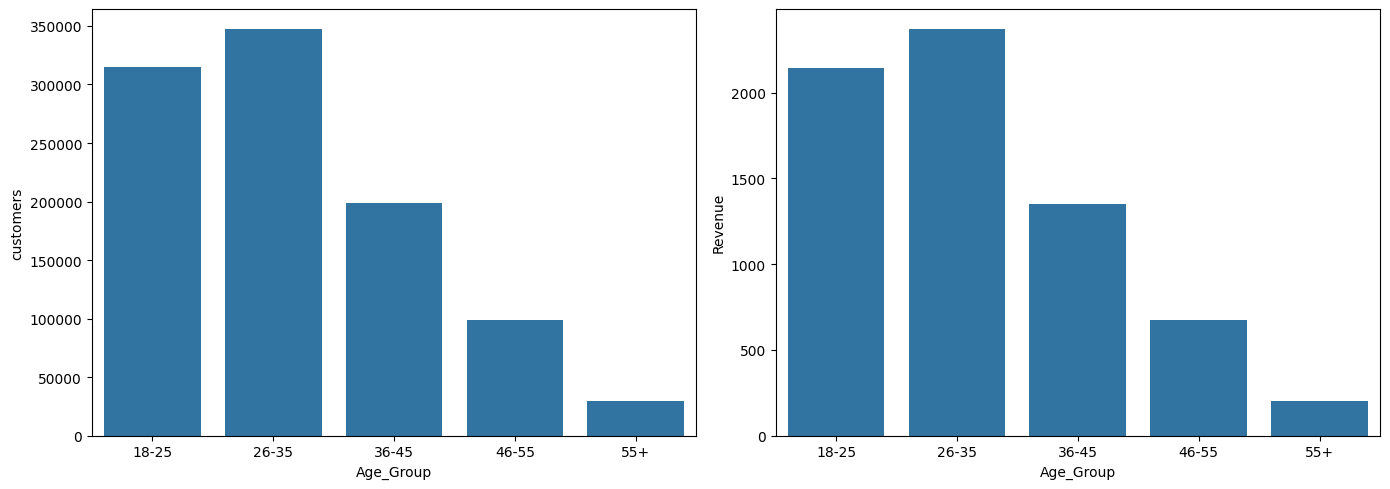

In [31]:
fig, axes = plt.subplots(1,2, figsize=(14,5))
sns.barplot(df_age_rev.groupby('Age_Group').sum(['cutomers','revenue']).reset_index(), x='Age_Group', y='customers', ax=axes[0])
sns.barplot(df_age_rev.groupby('Age_Group').sum(['cutomers','revenue']).reset_index(), x='Age_Group', y='Revenue', ax=axes[1])
plt.tight_layout()
plt.show()

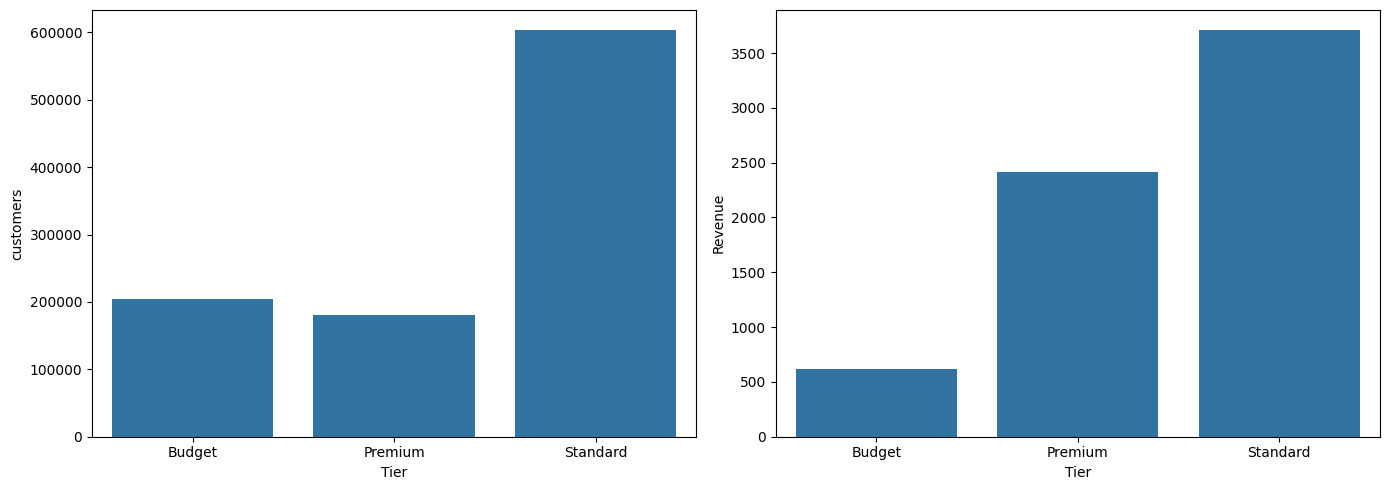

In [32]:
fig, axes = plt.subplots(1,2, figsize=(14,5))
sns.barplot(df_age_rev.groupby('Tier').sum(['cutomers','revenue']).reset_index(), x='Tier', y='customers', ax=axes[0])
sns.barplot(df_age_rev.groupby('Tier').sum(['cutomers','revenue']).reset_index(), x='Tier', y='Revenue', ax=axes[1])
plt.tight_layout()
plt.show()

<Axes: xlabel='category', ylabel='Revenue'>

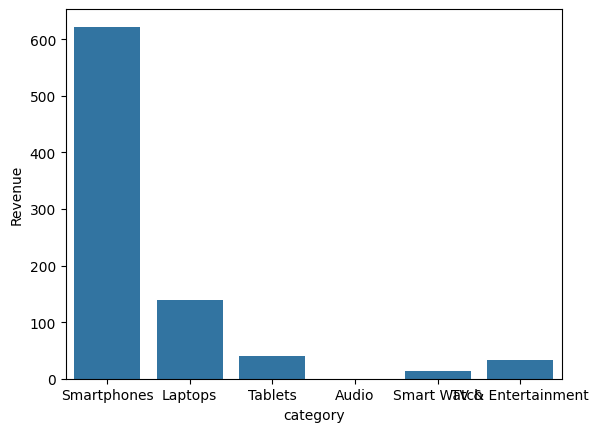

In [35]:
cond = (df_age_rev['Age_Group'] == '26-35') & (df_age_rev['Tier'] == 'Premium')
df_age_rev[cond]
sns.barplot(df_age_rev[cond], x='category', y='Revenue')

In [52]:
sql = """select s.name category,p.name product, sum(t.Quantity) quantity, FORMAT(FLOOR(t.Discount),0) discount 
        from transaction t
        join product p
            on t.product_id = p.id
        join product_subcategory s
            on p.SubCategory_Id = s.id
        group by  s.name, p.name, FORMAT(FLOOR(t.Discount),0)"""

df_disc_sale = pd.read_sql(sql, connection)
df_disc_sale

C:\Users\raagh\AppData\Local\Temp\ipykernel_12088\980589316.py:9: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



category                           product  quantity  \
0                    Audio  Audio-Technica Bluetooth Speaker     304.0   
1                    Audio  Audio-Technica Bluetooth Speaker      10.0   
2                    Audio  Audio-Technica Bluetooth Speaker       6.0   
3                    Audio  Audio-Technica Bluetooth Speaker       6.0   
4                    Audio  Audio-Technica Bluetooth Speaker       6.0   
...                    ...                               ...       ...   
104009  TV & Entertainment          Samsung Smart TV Premium       7.0   
104010  TV & Entertainment          Samsung Smart TV Premium       9.0   
104011  TV & Entertainment          Samsung Smart TV Premium      14.0   
104012  TV & Entertainment          Samsung Smart TV Premium       9.0   
104013  TV & Entertainment          Samsung Smart TV Premium      14.0   

       discount  
0             0  
1            10  
2            11  
3            12  
4            13  
...         ...  
104009       68  
104010       69  
104011        7  
104012        8  
104013        9  

[104014 rows x 4 columns]

In [54]:
df_disc_sale['discount'] = df_disc_sale['discount'].astype(int)
df_disc_sale.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104014 entries, 0 to 104013
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   category  104014 non-null  object 
 1   product   104014 non-null  object 
 2   quantity  104014 non-null  float64
 3   discount  104014 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


<Axes: xlabel='discount', ylabel='quantity'>

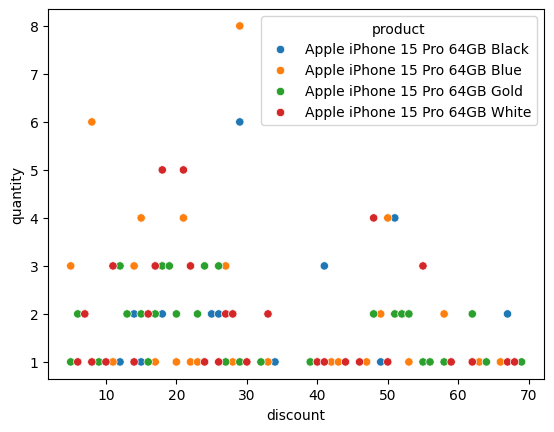

In [65]:
cond = (df_disc_sale['discount'] > 0) & (df_disc_sale['category']=='Smartphones') & (df_disc_sale['product'].str.contains('Apple iPhone 15 Pro 64'))
plt.Figure(figsize=(16,4))
sns.scatterplot(df_disc_sale[cond], x='discount', y='quantity', hue='product')

In [68]:
sql = """select s.name category, b.name brand, sum(t.Quantity)/1000 quantity, round(sum(Final_Amount)/10000000,2) revenue
        from transaction t
        join product p
            on t.product_id = p.id
        join product_subcategory s
            on p.SubCategory_Id = s.id
        join product_brand b
            on p.Brand_Id = b.Id
        group by  s.name,b.name """

df_brand_rev = pd.read_sql(sql, connection)
df_brand_rev

C:\Users\raagh\AppData\Local\Temp\ipykernel_12088\2326136893.py:11: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



category           brand  quantity  revenue
0                Audio  Audio-Technica    10.748    19.49
1                Audio            Boat     6.007     9.22
2                Audio             JBL     9.545    17.56
3                Audio         OnePlus     8.234    15.37
4                Audio          Realme     7.452    14.18
5                Audio      Sennheiser     7.829    12.84
6                Audio      Skullcandy     5.576     8.84
7                Audio            Sony     7.443    13.07
8              Laptops            Acer    17.438   141.03
9              Laptops       Alienware    18.159   165.17
10             Laptops           Apple    10.764    96.63
11             Laptops            ASUS    16.094   145.15
12             Laptops            Dell    11.645    97.07
13             Laptops              HP    11.358    89.80
14             Laptops          Lenovo    11.620    92.69
15             Laptops             MSI    12.584   107.68
16         Smart Watch         Amazfit    10.609    38.17
17         Smart Watch           Apple     8.371    29.92
18         Smart Watch      Fire-Boltt     9.878    30.86
19         Smart Watch          Fitbit    13.123    45.05
20         Smart Watch          Garmin    13.692    48.85
21         Smart Watch           Noise    12.914    43.02
22         Smart Watch         Samsung     8.449    27.68
23         Smart Watch          Xiaomi    15.788    56.24
24         Smartphones           Apple   102.394  1402.11
25         Smartphones            iQOO     4.425     4.52
26         Smartphones        Motorola    42.994    71.93
27         Smartphones         Nothing    14.376    40.73
28         Smartphones         OnePlus   198.115  1153.94
29         Smartphones            Oppo    88.486   225.84
30         Smartphones          Realme    85.017   211.65
31         Smartphones         Samsung   241.552  1821.33
32         Smartphones            Vivo    88.265   233.61
33         Smartphones          Xiaomi   163.707   421.41
34             Tablets           Apple    17.674    95.29
35             Tablets          Lenovo    16.597   114.80
36             Tablets         OnePlus    10.616    56.60
37             Tablets          Realme    12.928    74.25
38             Tablets         Samsung    14.549   100.38
39             Tablets          Xiaomi    15.099    64.59
40  TV & Entertainment              LG     7.920    88.57
41  TV & Entertainment         Samsung    12.505   102.70

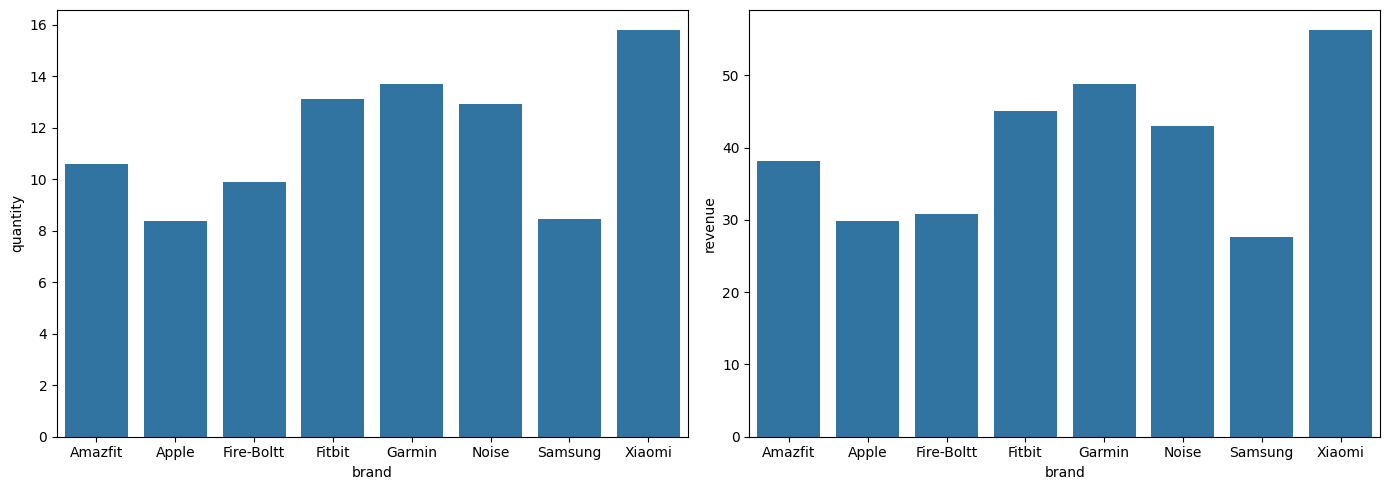

In [ ]:
df = df_brand_rev[df_brand_rev['category'] == 'Smart Watch']
#df = df_brand_rev[df_brand_rev['category'] == 'Smartphones']
fig, axes = plt.subplots(1,2, figsize=(14,5))
sns.barplot(df, x='brand', y='quantity', ax=axes[0])
sns.barplot(df, x='brand', y='revenue', ax=axes[1])
plt.tight_layout()
plt.show()


In [74]:
sql = """select p.Rating, s.name category, sum(Quantity)/1000 quantity, round(sum(Final_Amount)/10000000,2)  Revenue
    from transaction t
    join product p
        on t.Product_Id = p.id
    join product_subcategory s
        on p.SubCategory_Id = s.Id
    group by p.Rating, s.name"""

df_rating_rev = pd.read_sql(sql, connection)
df_rating_rev

C:\Users\raagh\AppData\Local\Temp\ipykernel_12088\4842667.py:9: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



Rating     category  quantity  Revenue
0       3.0        Audio     3.053     5.87
1       3.0      Laptops     1.933    22.50
2       3.0  Smart Watch     2.805    11.69
3       3.0      Tablets     0.508     4.27
4       3.1        Audio     1.982     3.03
..      ...          ...       ...      ...
99      4.7      Tablets     3.344    18.85
100     4.8        Audio     1.864     3.97
101     4.8      Laptops     1.959     5.44
102     4.8  Smart Watch     7.386    31.41
103     4.8      Tablets     7.670    47.52

[104 rows x 4 columns]

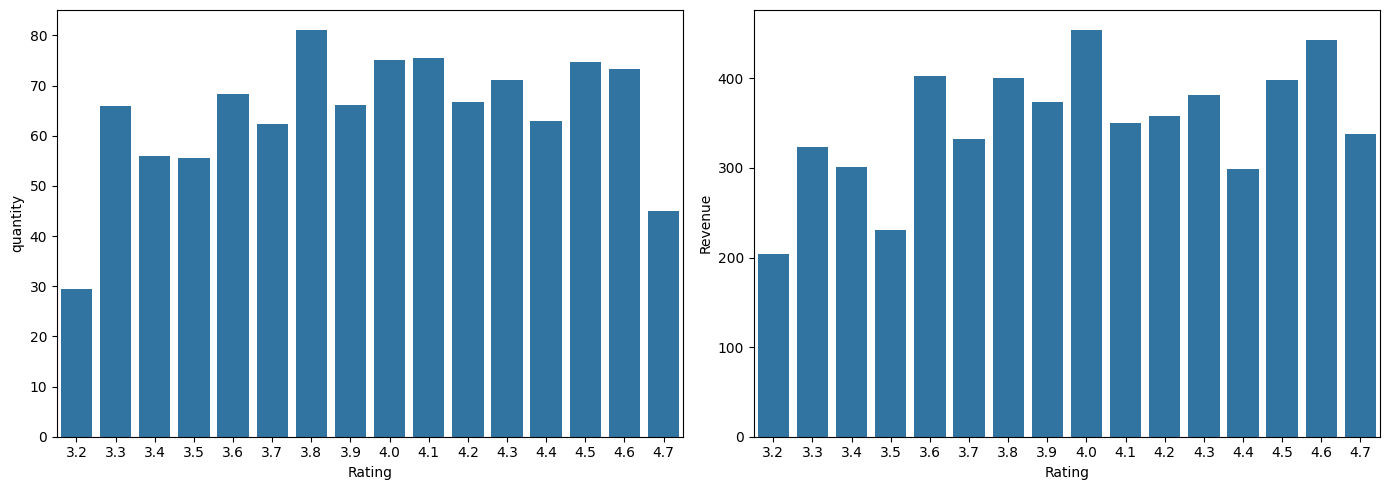

In [77]:
df = df_rating_rev[df_rating_rev['category'] == 'Smartphones'] 
fig, axes = plt.subplots(1,2, figsize=(14,5))
sns.barplot(df, x='Rating', y='quantity', ax=axes[0])
sns.barplot(df, x='Rating', y='Revenue', ax=axes[1])
plt.tight_layout()
plt.show()